$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
$$

In [2]:
# plotting
%matplotlib inline
from matplotlib import pyplot as plt;

# scientific
import numpy as np;

In [3]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'theme': 'simple',
              'transition': 'none',
              'start_slideshow_at': 'beginning',
});

# EECS 545:  Machine Learning
## Lecture 04:  Linear Regression
* Instructor:  **Jacob Abernethy**
* Date:  January 20, 2015


*Lecture Exposition Credit: Benjamin Bray*

# Supervised Learning

- Goal
    - Given data $X$ in feature sapce and the labels $Y$
    - Learn to predict $Y$ from $X$
- Labels could be discrete or continuous
    - Discrete-valued labels:  Classification
    - Continuous-valued labels:  Regression
    
<img src="images/classification-regression.png">

# Notation

In this lecture, we will use
- Data $x \in \R^D$ (scalar- or vector-valued)
- Features $\phi(x) \in \R^M$ for data $x$
- Continuous-valued labels $t \in \R$ (target values)
 
We will interchangeably use

- $x^{(n)}, x_n$ to denote the $n^\text{th}$ training example.
- $t^{(n)}, t_n$ to denote the $n^\text{th}$ target value.

# Linear Regression (1d inputs)

- Consider 1d case (e.g. D=1)
    - Given a set of observations $x_1, \dots, x_N$
    - and corresponding target values $t_1, \dots, t_N$
- We want to learn a function $y(x, \vec{w}) \approx t$ to predict future values.

$$
y(x, \vec{w})
= w_0 + w_1 x + w_2 x^2 + \dots w_M x^M
= \sum_{k=0}^M w_k x^k
$$

## Regression: Noisy Data

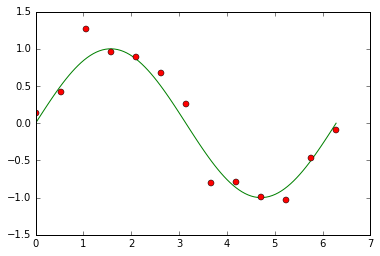

In [15]:
# plot sine wave
xx = np.linspace(0, 2*np.pi, 100);
plt.plot(xx, np.sin(xx), '-g');

x = np.linspace(0, 2*np.pi, 13);
# np.random.randn generates gaussian samples
y = np.sin(x) + np.random.randn(x.shape[0]) / 5; 

# plot data
plt.plot(x,y, 'or');

## Regression:  0th Order Polynomial

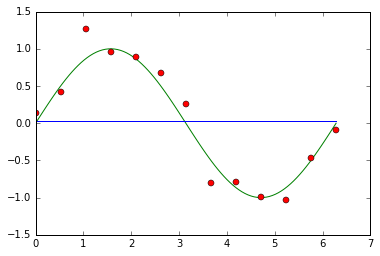

In [18]:
# Here were are going to take advantage of numpy's 'polyfit' function
# This implements a "polynomial fitting" algorithm
# coeffs are the optimal coefficients of the polynomial
coeffs = np.polyfit(x, y, 0); # 0 is the degree of the poly

# We construct poly(), the polynomial with "learned" coefficients
poly = np.poly1d(coeffs);

plt.plot(xx, np.sin(xx), "-g", x, y, "or", xx, poly(xx), "-b");

## Regression:  1st Order Polynomial

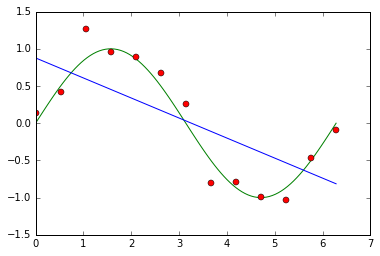

In [19]:
coeffs = np.polyfit(x, y, 1); # Now let's try degree = 1
poly = np.poly1d(coeffs);
plt.plot(xx, np.sin(xx), "-g", x, y, "or", xx, poly(xx), "-b");

## Regression:  3rd Order Polynomial

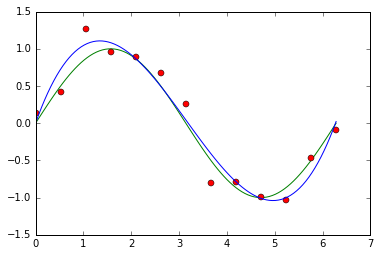

In [20]:
coeffs = np.polyfit(x, y, 3); # Now degree = 3
poly = np.poly1d(coeffs);
plt.plot(xx, np.sin(xx), "-g", x, y, "or", xx, poly(xx), "-b");

## Linear Regression (General Case)

The function $y(\vec{x}, \vec{w})$ is linear in parameters $\vec{w}$.
- **Goal:** Find the best value for the weights, $\vec{w}$.
- For simplicity, add a **bias term** $\phi_0(\vec{x}) = 1$.

$$
y(\vec{x}, \vec{w}) 
= w_0 + \sum_{j=0}^{M-1} w_j \phi_j(\vec{x})
= \vec{w}^T \phi(\vec{x})
$$


## Basis Functions

The basis functions $\phi_j(\vec{x})$ need not be linear.

In [22]:
def set_nice_plot_labels(axs):
    axs[0].set_title(r"$ \phi_j(x) = x^j$", fontsize=18, y=1.08);
    axs[0].set_xlabel("Polynomial", fontsize=18);
    axs[1].set_title(r"$ \phi_j(x) = \exp\left( - \frac{(x-\mu_j)^2}{2s^2} \right)$", fontsize=18, y=1.08);
    axs[1].set_xlabel("Gaussian", fontsize=18);
    axs[2].set_title(r"$ \phi_j(x) = (1  + \exp\left(\frac{\mu_j-x}{s}\right))^{-1}$", fontsize=18, y=1.08);
    axs[2].set_xlabel("Sigmoid", fontsize=18);

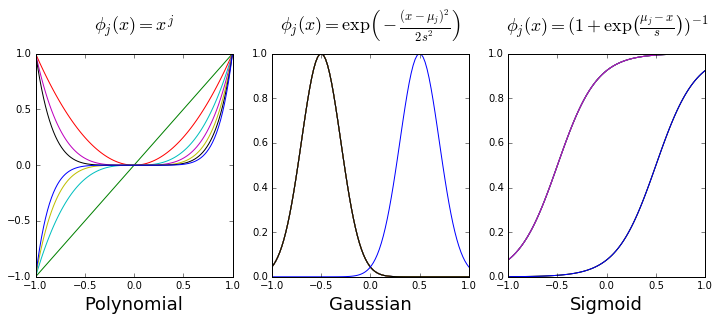

In [24]:
x = np.linspace(-1,1,100);
f, axs = plt.subplots(1, 3, sharex=True, figsize=(12,4));
for j in range(8):
    axs[0].plot(x, np.power(x,j));
    axs[1].plot(x, np.exp( - (x - j/7 + 0.5)**2 / 2*5**2 ));
    axs[2].plot(x, 1 / (1 + np.exp( - (x - j/5 + 0.5) * 5)) );
    
set_nice_plot_labels(axs) # I'm hiding some helper code that adds labels

## Least Squares:  Objective Function

Minimize the residual error over the training data.

$$
E(\vec{w}) 
= \frac12 \sum_{n=1}^N (y(x_n, \vec{w}) - t_n)^2
= \frac12 \sum_{n=1}^N \left( \sum_{j=0}^{M-1} w_j\phi_j(\vec{x}^{(n)}) - t^{(n)} \right)^2
$$

<img src="images/least-squares-objective.png">


## Least Squares:  Gradient Calculation

To minimize the error, take partial derivatives w.r.t. each weight $w_j$:

$$
\frac{\partial E(\vec{w})}{\partial w_k}= \frac{\partial}{\partial w_k} \left[ 
    \sum_{n=1}^N \left( \sum_{j=0}^{M-1} w_j\phi_j(\vec{x}^{(n)}) - t^{(n)} \right)^2
    \right]
$$

Apply the chain rule:

$$
= \sum_{n=1}^N \left[ \left( \sum_{j=0}^{M-1} w_j\phi_j(\vec{x}^{(n)}) - t^{(n)} \right)
  \frac{\partial}{\partial w_k}  \left[ \sum_{j=0}^{M-1} w_j\phi_j(\vec{x}^{(n)}) - t^{(n)} \right] \right]
$$

$$
= \sum_{n=1}^N \left[ 
    \left( \sum_{j=0}^{M-1} w_j\phi_j(\vec{x}^{(n)}) - t^{(n)} \right)
    \phi_k(\vec{x}^{(n)}) 
  \right]
$$

## Least Squares:  Vectorized Gradient

$$
\begin{align}
\nabla_w E(\vec{w})
&= \sum_{n=1}^N \left( \sum_{j=0}^{M-1} w_j \phi_j(\vec{x}^{(n)}) - t^{(n)} \right) \phi(\vec{x}^{(n)}) \\
&= \sum_{n=1}^N \left( \vec{w}^T \phi(\vec{x}^{(n)}) - t^{(n)} \right) \phi(\vec{x}^{(n)})
\end{align}
$$

## Batch Gradient Descent

Given dataset $\{ (x,t) \}$ and initial guess $\vec{w}_0$, repeat until convergence:

- $\vec{w} = \vec{w} - \eta \nabla_\vec{w} E(\vec{w})$

where

$$
\begin{align}
\nabla_w E(\vec{w})
&= \sum_{n=1}^N \left( \sum_{j=0}^{M-1} w_j \phi_j(\vec{x}^{(n)}) - t^{(n)} \right) \phi(\vec{x}^{(n)}) \\
&= \sum_{n=1}^N \left( \vec{w}^T \phi(\vec{x}^{(n)}) - t^{(n)} \right) \phi(\vec{x}^{(n)})
\end{align}
$$

## Stochastic Gradient Descent

**Main Idea:**  Instead of computing batch gradient (over entire training data), just compute gradient for individual example and update.

**Repeat** until convergence:
- `for` $n=1,\dots,N$ `do:` <br>
    - $w := w - \eta \nabla_\vec{w} E(\vec{w} | \vec{x}^{(n)})$
    
where

$$
\begin{align}
\nabla_w E(\vec{w} | \vec{x}^{(n)})
&= \left( \sum_{j=0}^{M-1} w_j \phi_j(\vec{x}^{(n)}) - t^{(n)} \right) \phi(\vec{x}^{(n)}) \\
&= \left( \vec{w}^T \phi(\vec{x}^{(n)}) - t^{(n)} \right) \phi(\vec{x}^{(n)})
\end{align}
$$

## Closed Form Solution

**Main Idea:**  Compute gradient and set to gradient to zero, solving in closed form.
- Objective function:  $$E(\vec{w}) = \frac12 \sum_{n=1}^N \left( \sum_{j=0}^{M-1} w_j\phi_j(\vec{x}^{(n)})\right)^2$$
- We will derive the gradient using matrix calculus.

### Closed Form Solution:  Derivation

$$
\begin{align}
E(\vec{w}) 
&=  \frac12 \sum_{n=1}^N \left( 
        \sum_{j=1}^{M-1} 
           w_j \phi_j(\vec{x}^{(n)}) - t^{(n)} 
    \right)^2 \\
&=  \frac12 \sum_{n=1}^N \left(
        \vec{w}^T \phi(\vec{x}^n) - t^{(n)}
    \right)^2 \\
&= \frac12 \sum_{n=1}^N  (\vec{w}^T \phi( \vec{x}^{(n)} ) )^2
 -         \sum_{n=1}^N  t^{(n)} \vec{w}^T \phi( \vec{x}^{(n)} )
 + \frac12 \sum_{n=1}^N  (t^{(n)})^2 \\
&= \frac12 \vec{w}^T \Phi^T \Phi \vec{w} - \vec{w}^T \Phi^T \vec{t} + \frac12 \vec{t}^T \vec{t}
\end{align}$$

## Closed Form Solution:  Data Matrix

The **design matrix** is a matrix $\Phi \in \R^{N \times M}$, applying
- the $M$ basis functions (columns)
- to $N$ data points (rows)

$$
\Phi = \begin{bmatrix}
\phi_0(\vec{x}_1) & \phi_1(\vec{x}_1) & \cdots & \phi_{M-1}(\vec{x}_1) \\
\phi_0(\vec{x}_2) & \phi_1(\vec{x}_2) & \cdots & \phi_{M-1}(\vec{x}_2) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_0(\vec{x}_N) & \phi_1(\vec{x}_N) & \cdots & \phi_{M-1}(\vec{x}_N) \\
\end{bmatrix}
$$

**Goal:** $\Phi \vec{w} \approx \vec{t}$

## Closed Form:  Recap

- Idea so far:
    - Compute gradient and set to zero
    - Solve the equation in a closed form using matrix calculus
- Need to compute the first derivative of objective $E(\vec{w})$ in matrix form!

## Matrix Calculus:  The Gradient

Suppose that $f : \R^{m \times n} \mapsto \R$, that is, the function $f$
- takes as input a matrix $A \in \R^{m\times n} = [a_{ij}]$
- returns a real value

Then, the **gradient** of $f$ with respect to $A$ is:

$$
\nabla_A f(A) \in \R^{m \times n} = \begin{bmatrix}
%
\frac{\partial f}{\partial a_{11}}
    & \frac{\partial f}{\partial a_{12}} 
    & \cdots 
    & \frac{\partial f}{\partial a_{1n}} \\ 
%
\frac{\partial f}{\partial a_{21}}
    & \frac{\partial f}{\partial a_{22}} 
    & \cdots 
    & \frac{\partial f}{\partial a_{2n}} \\
%
\vdots & \vdots & \ddots & \vdots \\
%
\frac{\partial f}{\partial a_{m1}}
    & \frac{\partial f}{\partial a_{m2}} 
    & \cdots 
    & \frac{\partial f}{\partial a_{mn}} \\ 
\end{bmatrix}
$$

$$
[\nabla_A f(A)]_{ij} = \frac{\partial f}{\partial a_{ij}}
$$

## Matrix Calculus:  The Gradient

Note that the size of $\nabla_A f(A)$ is always the same as the size of $A$.  In particular, for vectors $x \in \R^n$,

$$
\nabla_x f(x) = \begin{bmatrix}
    \frac{\partial f}{\partial x_1} &
    \frac{\partial f}{\partial x_2} &
    \cdots &
    \frac{\partial f}{\partial x_n}
\end{bmatrix}^T
$$

The gradient is a **linear operator** from $\R^n \mapsto \R^n$:

- $ \nabla_x (f + g) = \nabla_x f + \nabla_x g $
- $ \forall\, c \in \R, \nabla_x (c f) = c \nabla_x f$ 

## Gradient:  Linear Functions

The gradient of the **linear function** $f(x) = \sum_{k=1}^n b_k x_k = b^T x$ is

$$
\frac{\partial f}{\partial x_k}
= \frac{\partial}{\partial x_k} \sum_{k=1}^n b_k x_k
= \sum_{k=1}^n \frac{\partial}{\partial x_k} b_k x_k
= b_k
$$

In a more compact form,

$$
\nabla_x b^T x = b
$$

## Gradient:  Quadratic Forms

- Every symmetric $A \in \R^{n \times n}$ corresponds to a **quadratic form**:
    $$ f(x) = \sum_{i=1}^n \sum_{j=1}^n x_i A_{ij} x_j = x^T A x $$
- The partial derivatives are
    $$ 
    \frac{\partial f}{\partial x_k}
    = 2 \sum_{j=1}^n A_{ij} x_j
    = 2 [Ax]_i
    $$
- Compact form $\nabla_x f(x) = 2 Ax$

## Digression: Moore-Penrose Pseudoinverse
* When we have a matrix $A$ that is non-invertible or *not even square*, we might want to invert anyway
* For these situations we use $A^\dagger$, the *Moore-Penrose Pseudoinverse* of $A$
* When $A$ has lin. indep. columns then $A^\dagger = (A^\top A)^{-1} A^\top$
* In general, we can get $A^\dagger$ by SVD: if we write $A = U \Sigma V^\top$ then $A^\dagger = V \Sigma^\dagger U^\top$, where $\Sigma^\dagger$ is obtained by taking reciprocals of *non-zero entries* of $\Sigma^\top$.

## Least Squares:  Gradient via Matrix Calculus

- Compute the gradient and set to zero
    $$
    \begin{align}
    \nabla_w E(w)
    &= \nabla_w \left[ 
           \frac12 w^T \Phi^T \Phi w - w^T \Phi^T t + \frac12 t^T t 
       \right] \\
    &= \Phi^T \Phi w - \Phi^T t = 0
    \end{align}
    $$
- Solve the resulting **normal equation**:
    $$
    \Phi^T \Phi w = \Phi^T t \\
    w_{ML} = (\Phi^T \Phi)^{-1} \Phi^T t
    $$

> This is the *Moore-Penrose pseudoinverse*, $\Phi^\dagger = (\Phi^T \Phi)^{-1} \Phi^T$ applied to solve the linear system $\Phi w \approx t$.

## Least Squares:  Geometric Interpretation

- Assume data much larger than basis dim (i.e. $N >> M$)
- View target vals $\mathbf t = (t_1, \dots, t_n)$ as a vector in $n$-dim space
    - The $M$ basis functions span the $M$-dim subspace
- $y(x, w_{ML})$ minimizes squared err from $\mathbf{t}$ in subspace
    - Proj of $t$ onto $M$-dim subspace spanned by basis funcs
    
<img src="images/least-squares-projection.png" width=500px>

## Back to curve-fitting examples...

## Polynomial Curve Fitting

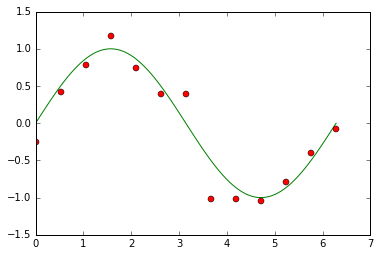

In [9]:
# plot sine wave
xx = np.linspace(0, 2*np.pi, 100);
plt.plot(xx, np.sin(xx), '-g');

# plot data
x = np.linspace(0, 2*np.pi, 13);
y = np.sin(x) + np.random.randn(x.shape[0]) / 5;
plt.plot(x,y, 'or');

$$y(x, w) = w_0 + w_1x + w_2 x^2 + \cdots + w_M x^M = \sum_{j=0}^M w_j x^j$$

## 0th Order Polynomial

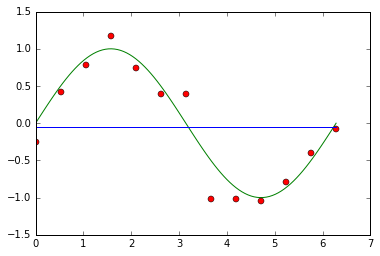

In [10]:
coeffs = np.polyfit(x, y, 0);
poly = np.poly1d(coeffs);
plt.plot(xx, np.sin(xx), "-g", x, y, "or", xx, poly(xx), "-b");

## 3rd Order Polynomial

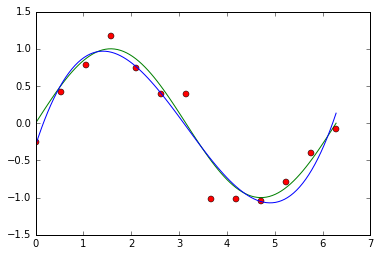

In [11]:
coeffs = np.polyfit(x, y, 3);
poly = np.poly1d(coeffs);
plt.plot(xx, np.sin(xx), "-g", x, y, "or", xx, poly(xx), "-b");

## 12th Order Polynomial

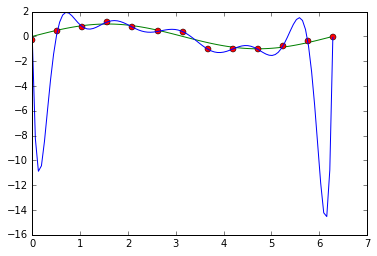

In [12]:
coeffs = np.polyfit(x, y, 12);
poly = np.poly1d(coeffs);
plt.plot(xx, np.sin(xx), "-g", x, y, "or", xx, poly(xx), "-b");

## Overfitting

<img src='images/overfitting.png' width=500px/>

Root-Mean-Square (RMS) Error:  $E_{RMS} = \sqrt{2E(w^*) / N}$

## Polynomial Coefficients

![Polynomial Coefficients](images/polynomial-coefficients.png)

## Data Set Size:  $N = 15$

(12th order polynomial)

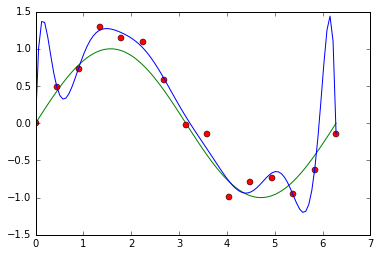

In [13]:
# sine wave
xx = np.linspace(0, 2*np.pi, 100);
# data
N = 15;
x = np.linspace(0, 2*np.pi, N);
y = np.sin(x) + np.random.randn(x.shape[0]) / 5;
# fit
coeffs = np.polyfit(x, y, 12);
poly = np.poly1d(coeffs);
plt.plot(xx, np.sin(xx), "-g", x, y, "or", xx, poly(xx), "-b");

## Data Set Size:  $N = 100$

(12th order polynomial)

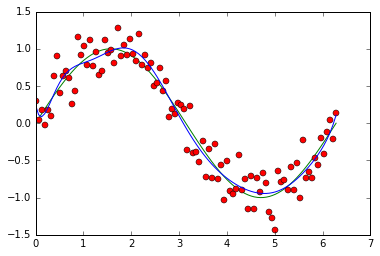

In [14]:
# sine wave
xx = np.linspace(0, 2*np.pi, 100);
# data
N = 100;
x = np.linspace(0, 2*np.pi, N);
y = np.sin(x) + np.random.randn(x.shape[0]) / 5;
# fit
coeffs = np.polyfit(x, y, 12);
poly = np.poly1d(coeffs);
plt.plot(xx, np.sin(xx), "-g", x, y, "or", xx, poly(xx), "-b");

# How do we choose the degree of our polynomial?

## Rule of Thumb

- For a small number of datapoints, use a low degree
    - Otherwise, the model will overfit!
- As you obtain more data, you can gradually increase the degree
    - Add more features to represent more data
    - **Warning:**  Your model is still limited by the finite amount of data available.  The optimal model for finite data cannot be an infinite-dimensional polynomial!)
- Use **regularization** to control model complexity.

# Regularized Linear Regression

## Regularized Least Squares

- Consider the error function $E_D(w) + \lambda E_W(w)$
    - Data term $E_D(w)$
    - Regularization term $E_W(w)$
- With the sum-of-squares error function and quadratic regularizer,
    $$
    \widetilde{E}(w)
    = \frac12 \sum_{n=1}^N (y(x_n, w) - t_n)^2
    - \boxed{\frac{\lambda}{2} || w ||^2}
    $$
- This is minimized by
    $$
    w = (\lambda I + \Phi^T \Phi)^{-1} \Phi^T t
    $$

## Regularized Least Squares:  Derivation

Recall that our objective function is
    $$
    \begin{align}
    E(w)
    &= \frac12 \sum_{n=1}^N (w^T \phi(x^{(n)}) - t^{(n)})^2
     + \frac{\lambda}{2} w^T w \\
    &= \frac12 w^T \Phi^T \Phi w - w^T \Phi^T t + \frac12 t^T t + \frac{\lambda}{2} w^T w
    \end{align}
    $$

## Regularized Least Squares:  Derivation

Compute gradient and set to zero:
    $$
    \begin{align}
    \nabla_w E(w)
    &= \nabla_w \left[ 
           \frac12 w^T \Phi^T \Phi w - w^T \Phi^T t + \frac12 t^T t 
           + \frac{\lambda}{2} w^T w
       \right] \\
    &= \Phi^T \Phi w - \Phi^T t + \lambda w \\
    &= (\Phi^T \Phi + \lambda I) w - \Phi^T t = 0
    \end{align}
    $$

Therefore, we get $\boxed{w_{ML} = (\Phi^T \Phi + \lambda I)^{-1} \Phi^T t}$

## Regularized Least Squares:  Norms

We can make use of the various $L_p$ norms for different regularizers:

$$
\widetilde{E}(w)
= \frac12 \sum_{n=1}^N (t_n - w^T \phi(x_n))^2
+ \frac{\lambda}{2} \sum_{j=1}^M |w_j|^q
$$

![Norms](images/p-norms.png)

## Regularized Least Squares:  Comparison

Lasso tends to generate sparser solutions than a quadratic regularizer.

![Regularization](images/lasso-vs-ridge.png)

## L2 Regularization:  $\ln\lambda = -18$

![L2 Regularization](images/l2-reg-lambda-18.png)

## L2 Regularization:  $\ln\lambda = 0$

![L2 Regularization](images/l2-reg-lambda-0.png)

## L2 Regularization:  $E_{RMS}$ vs $\ln\lambda$

![E_RMS vs ln(lambda)](images/l2-reg-erms-vs-lambda.png)

> NOTE: For simplicity of presentation, we divided the data into training set and test set. However, it’s not legitimate to find the optimal hyperparameter based on the test set. We will talk about legitimate ways of doing this when we cover model selection and cross-validation.

## L2 Regularization:  Polynomial Coefficients

![Polynomial Coefficients](images/l2-reg-coeffs.png)

## Regularized Least Squares:  Summary

- Simple modification of linear regression
- L2 Regularization controls the tradeoff between *fitting error* and *complexity*.
    - Small L2 regularization results in complex models, but with risk of overfitting
    - Large L2 regularization results in simple models, but with risk of underfitting
- It is important to find an optimal regularization that *balances* between the two